In [14]:
## PFP-API
from pfp_api_client import Estimator, ASECalculator

## Matlantis Features
from matlantis_features.utils.calculators import pfp_estimator_fn
from matlantis_features.atoms import MatlantisAtoms
from matlantis_features.features.common.opt import FireLBFGSASEOptFeature
from matlantis_features.features.md import (ASEMDSystem, MDFeature, MDExtensionBase,
                                            NVTBerendsenIntegrator, NPTIntegrator, NPTBerendsenIntegrator)
from matlantis_features.features.md.md_extensions import TemperatureScheduler


## PFCC_extras
from pfcc_extras.liquidgenerator.liquid_generator import LiquidGenerator
from pfcc_extras.structure.molecule import get_mol_list
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.connectivity import exists_colliding_atom

## ASE
from ase import units
from ase.io import read, write, Trajectory
from ase.optimize import LBFGS, FIRE
from ase.md import MDLogger
from ase.md.nptberendsen import NPTBerendsen
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary

## Python General
from collections import Counter
from joblib import Parallel, delayed
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from time import perf_counter

In [31]:
import numpy as np
from ase import units
from ase.io import read, write

# Matlantis / PFCC Extras のライブラリをインポート
from matlantis_features.features.md import ASEMDSystem, NPTIntegrator, MDFeature
from matlantis_features.utils.calculators import pfp_estimator_fn
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms
from pfcc_extras.liquidgenerator.liquid_generator import LiquidGenerator

# --- ユーザー設定項目 ---

# 1. 生成する分子の情報
# Epoxy分子のSMILES式 (ご自身の分子に合わせて変更してください)
smiles_string = "C1(O1)C(C)C"  
num_molecules = 30  # 充填する分子の数
input_file="/home/jovyan/Kaori/MD/input/pvdfchain.gjf"
# 2. 初期構造生成の条件
initial_density = 0.8  # 初期充填密度 (g/cm³) 
lg_epochs = 100        # LiquidGeneratorの最適化エポック数

# 3. 出力ファイル
output_traj_path = "lg_compressed.traj"
output_final_xyz_path = "lg_compressed_final.xyz"

# 4. 圧縮シミュレーションの条件
temperature = 473.0  # 高温で緩和を促進 (K)
pressure = 0.1       # 圧縮圧力 (GPa)
n_steps = 75000      # MD計算のステップ数
time_step = 1.0      # タイムステップ (fs)

# --- Matlantis PFP計算機の設定 ---
estimator_fn = pfp_estimator_fn(model_version='v5.0.0', calc_mode='crystal_u0_plus_d3')


# --- メインプログラム ---

def main():
    """
    LiquidGeneratorによる構造生成とNPT圧縮を自動で行うメイン関数
    """
    print("--- STEP 1: SMILESから単一分子構造を準備します ---")
    atoms_pvdf = read(input_file)
    # print(f"生成する分子: {smiles_string}, 原子数: {len(atoms_pvdf)}")

    # 分子の質量を計算 (g/mol)
    mass_per_molecule = sum(atoms_pvdf.get_masses())
    total_mass = mass_per_molecule * num_molecules

    # 初期密度からセルの体積と一辺の長さを計算
    # 体積 (Å^3) = (総質量[g/mol] / アボガドロ数) / (密度[g/cm^3]) * (1e24 [Å^3/cm^3])
    volume_A3 = (total_mass / units.mol) / (initial_density / 1e24)
    cell_side_length = volume_A3 ** (1/3)
    print(f"初期密度 {initial_density} g/cm³ に基づき、セルの一辺を {cell_side_length:.2f} Å に設定します。")
    
    
    print(f"\n--- STEP 2: LiquidGenerator を用いて低密度構造を生成します ---")
    
    params = {
        "cell": [[cell_side_length, 0, 0], [0, cell_side_length, 0], [0, 0, cell_side_length]],
        "composition": [atoms_pvdf] * num_molecules,
        "epochs": lg_epochs
    }

    # LiquidGeneratorを実行
    generator = LiquidGenerator("torch", **params)
    atoms = generator.run()
    atoms.pbc = True
    
    print(f"生成後の原子数: {len(atoms)}")
    print(f"生成時のセルサイズ (a, b, c): {atoms.cell.cellpar()[:3]}")
    write("pvdf_liquid_generator.xyz",atoms)

    print("\n--- STEP 3: NPT圧縮シミュレーションを開始します ---")
    print(f"設定: 温度={temperature} K, 圧力={pressure} GPa, ステップ数={n_steps}")
    
    system = ASEMDSystem(atoms)
    system.init_temperature(temperature)

    integrator = NPTIntegrator(
        timestep=time_step,
        temperature=temperature,
        pressure=pressure * units.GPa,
        ttime=20,
        pfactor=2e6 * units.GPa * (units.fs**2),
        mask=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # 全方向に圧縮
    )

    md = MDFeature(
        integrator,
        n_run=n_steps,
        traj_file_name=output_traj_path,
        traj_freq=100,
        estimator_fn=estimator_fn
    )

    md(system)

    print("\n--- STEP 4: シミュレーションが完了しました ---")
    
    final_atoms = read(output_traj_path, index=-1)
    write(output_final_xyz_path, final_atoms)
    
    final_density = (total_mass / units.mol) / (final_atoms.get_volume() * 1e-24)
    print(f"最終的なセルサイズ (a, b, c): {final_atoms.cell.cellpar()[:3]}")
    print(f"最終的な密度: {final_density:.3f} g/cm³")
    print(f"圧縮・安定化された最終構造を '{output_final_xyz_path}' に保存しました。")


if __name__ == "__main__":
    main()

--- STEP 1: SMILESから単一分子構造を準備します ---
初期密度 0.8 g/cm³ に基づき、セルの一辺を 28.81 Å に設定します。

--- STEP 2: LiquidGenerator を用いて低密度構造を生成します ---
step  score  cell_x  cell_y  cell_z


/home/jovyan/.py311/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


   0   23106.34 28.81 28.81 28.81
   1   21612.21 28.81 28.81 28.81
   2   20537.35 28.81 28.81 28.81
   3   22239.17 28.81 28.81 28.81
   4   21134.96 28.81 28.81 28.81
   5   20793.11 28.81 28.81 28.81
   6   20364.80 28.81 28.81 28.81
   7   19946.12 28.81 28.81 28.81
   8   19415.77 28.81 28.81 28.81
   9   19478.82 28.81 28.81 28.81
  10   19357.30 28.81 28.81 28.81
  11   19238.72 28.81 28.81 28.81
  12   19310.21 28.81 28.81 28.81
  13   19120.25 28.81 28.81 28.81
  14   18922.22 28.81 28.81 28.81
  15   18906.32 28.81 28.81 28.81
  16   19231.47 28.81 28.81 28.81
  17   18689.47 28.81 28.81 28.81
  18   18324.14 28.81 28.81 28.81
  19   18807.75 28.81 28.81 28.81
  20   18500.31 28.81 28.81 28.81
  21   18350.52 28.81 28.81 28.81
  22   18071.44 28.81 28.81 28.81
  23   18120.99 28.81 28.81 28.81
  24   17995.49 28.81 28.81 28.81
  25   17997.25 28.81 28.81 28.81
  26   17862.30 28.81 28.81 28.81
  27   17818.24 28.81 28.81 28.81
  28   17788.58 28.81 28.81 28.81
  29   17764.7

The MD trajectory will be saved at /home/jovyan/Kaori/MD/LiB_2/structure/lg_compressed.traj.
Note: The max disk size of /home/jovyan is about 98G.


  49   17532.91 28.81 28.81 28.81
生成後の原子数: 1080
生成時のセルサイズ (a, b, c): [28.81481934 28.81481934 28.81481934]

--- STEP 3: NPT圧縮シミュレーションを開始します ---
設定: 温度=473.0 K, 圧力=0.1 GPa, ステップ数=75000


KeyboardInterrupt: 

In [ ]:
temperature = 300.0  # 高温で緩和を促進 (K)
pressure = 1.0       # 圧縮圧力 (GPa)
n_steps = 75000      # MD計算のステップ数
time_step = 1.0      # タイムステップ (fs)
ats=Trajectory("output/30C12H12F12_opt_v6cU0d3.traj")[-1]
atoms.pbc = True
system = ASEMDSystem(atoms)
system.init_temperature(temperature)

integrator = NPTIntegrator(
    timestep=time_step,
    temperature=temperature,
    pressure=pressure * units.GPa,
    ttime=20,
    pfactor=2e6 * units.GPa * (units.fs**2),
    mask=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # 全方向に圧縮
)

md = MDFeature(
    integrator,
    n_run=n_steps,
    traj_file_name=output_traj_path,
    traj_freq=100,
    estimator_fn=estimator_fn
)

md(system)

print("\n--- STEP 4: シミュレーションが完了しました ---")

final_atoms = read(output_traj_path, index=-1)
write(output_final_xyz_path, final_atoms)

final_density = (total_mass / units.mol) / (final_atoms.get_volume() * 1e-24)
print(f"最終的なセルサイズ (a, b, c): {final_atoms.cell.cellpar()[:3]}")
print(f"最終的な密度: {final_density:.3f} g/cm³")
print(f"圧縮・安定化された最終構造を '{output_final_xyz_path}' に保存しました。")


The MD trajectory will be saved at /home/jovyan/Kaori/MD/LiB_2/structure/lg_compressed.traj.
Note: The max disk size of /home/jovyan is about 98G.


In [12]:
from collections import Counter
import pandas as pd
import numpy as np
from pfcc_extras import show_gui, view_ngl
from ase.io import Trajectory,read,write
## Assuming get_mol_list is defined elsewhere

def count_fragms(l_atoms, ref_fragm):
    df_list = [] # Create a list to hold dataframes
    for idx, atoms in enumerate(l_atoms):
        d_formula = dict(zip(ref_fragm, np.zeros(len(ref_fragm), dtype=int)))
        d_formula['time[ps]'] = idx * 0.1 * 500 / 1000  ## ps
        d_formula['T[K]'] = atoms.get_temperature()

        # This block should be indented to be inside the loop
        l_fragm_atoms = get_mol_list(atoms)[0]
        d_count = Counter([x.get_chemical_formula() for x in l_fragm_atoms])
        for fragm in ref_fragm:
            d_formula[fragm] = d_count[fragm]

        df_list.append(pd.DataFrame(d_formula, index=[idx]))

    # Concatenate all dataframes at the end for better performance
    if not df_list:
        return pd.DataFrame() # Return empty dataframe if list is empty
    
    return pd.concat(df_list)

In [ ]:
help(get_mol_list)

In [16]:
## set traj files
l_ftraj_path = [
    'output/30C12H12F12_nvt-prod_600K-30Kps-25ps.traj',
    'output/30C12H12F12_nvt-prod_800K-40Kps-25ps.traj',
    'output/30C12H12F12_nvt-prod_1000K-40Kps-25ps.traj',
]
atoms_ini = read('output/30C12H12F12_nvt-eq_v6cU0d3.traj',index=-1)

## set chemical formulas of fragments listed up in the original paper
ref_fragm = ["C12H12F12",  ## original epoxy
           "CH2O",
           "CO",
           "H2O",
           "H2",
           "CH4"
          ]

## get results (~15 min.)
l_rate_df = []
for ftraj in l_ftraj_path:
    l_atoms = [atoms_ini] + read(ftraj, index=':')
    df = count_fragms(l_atoms, ref_fragm)
    l_rate_df.append(df)

In [21]:
import pandas as pd
from ase.io import read
from collections import Counter
from typing import List, Dict, Any, Tuple, Optional

# --------------------------------------------------------------------------
# get_mol_list関数は既にインポート済み、またはこのファイル内に
# 定義されていることを前提とします。
#
# 例: from my_module import get_mol_list
# --------------------------------------------------------------------------

def find_unexpected_molecules(
    l_traj_path: List[str],
    atoms_ini: 'ase.atoms.Atoms',
    ref_fragm: List[str]
) -> pd.DataFrame:
    """
    複数のtrajectoryファイルを解析し、参照リストに含まれない分子を
    出現回数と共に集計する。

    Args:
        l_traj_path (List[str]): 解析対象のtrajectoryファイルパスのリスト。
        atoms_ini (ase.atoms.Atoms): 初期構造のAtomsオブジェクト。
        ref_fragm (List[str]): 解析対象として予め定義された分子式のリスト。

    Returns:
        pd.DataFrame: 解析対象外の分子の 'Formula' と 'Total Count' を持つ
                      データフレーム。出現回数順にソート済み。
    """
    all_molecules_counter = Counter()

    # セットに変換して高速なルックアップを可能にする
    ref_fragm_set = set(ref_fragm)

    print("解析を開始します...")

    # 各trajectoryファイルをループして解析
    for ftraj_path in l_traj_path:
        print(f"  - ファイルを処理中: {ftraj_path}")
        try:
            # Trajectoryから全フレームを読み込み、リストの先頭に初期構造を追加
            l_atoms = [atoms_ini] + read(ftraj_path, index=':')
        except FileNotFoundError:
            print(f"    ⚠️  警告: ファイルが見つかりませんでした。スキップします: {ftraj_path}")
            continue
        
        # 各フレーム内の分子をカウント
        for atoms in l_atoms:
            # get_mol_listで分子のリストを取得
            mols, _ = get_mol_list(atoms)
            
            # 各分子の化学式を取得し、カウンターを更新
            formulas_in_frame = [mol.get_chemical_formula() for mol in mols]
            all_molecules_counter.update(formulas_in_frame)

    # カウント結果から、参照リストに含まれない分子のみを抽出
    unexpected_molecules = {
        formula: count
        for formula, count in all_molecules_counter.items()
        if formula not in ref_fragm_set
    }

    # 存在しない場合は空のDataFrameを返す
    if not unexpected_molecules:
        return pd.DataFrame(columns=['Formula', 'Total Count'])

    # 抽出した分子をDataFrameに変換し、出現回数で降順ソート
    df = pd.DataFrame(
        unexpected_molecules.items(),
        columns=['Formula', 'Total Count']
    ).sort_values(by='Total Count', ascending=False).reset_index(drop=True)

    return df


# --- 実行部分 ---
if __name__ == '__main__':
    # 1. 解析条件の設定
    l_ftraj_path = [
        'output/30C12H12F12_nvt-prod_600K-30Kps-25ps.traj',
        'output/30C12H12F12_nvt-prod_800K-40Kps-25ps.traj',
        'output/30C12H12F12_nvt-prod_1000K-40Kps-25ps.traj',
    ]

    ref_fragm = [
        "C12H12F12",
        "CH2O",
        "CO",
        "H2O",
        "H2",
        "CH4"
    ]
    
    # 2. 初期構造の読み込み
    try:
        atoms_ini = read('output/30C12H12F12_nvt-eq_v6cU0d3.traj', index=-1)
    except FileNotFoundError:
        print("エラー: 初期構造ファイルが見つかりません。プログラムを終了します。")
        exit() # 初期構造がないと解析できないため終了

    # 3. 解析関数の実行
    unexpected_df = find_unexpected_molecules(l_ftraj_path, atoms_ini, ref_fragm)
    
    # 4. 結果の表示と保存
    print("\n--- 解析結果 ---")
    if unexpected_df.empty:
        print("✅ 解析対象外の分子は見つかりませんでした。")
    else:
        print("✅ 解析対象外の分子一覧 (全trajectoryの合計数):")
        print(unexpected_df.to_string()) # .to_string()ですべての行を表示

        # 結果をCSVファイルに保存
        output_csv_path = 'unexpected_molecules_summary.csv'
        unexpected_df.to_csv(output_csv_path, index=False)
        print(f"\n結果を '{output_csv_path}' に保存しました。")

解析を開始します...
  - ファイルを処理中: output/30C12H12F12_nvt-prod_600K-30Kps-25ps.traj
  - ファイルを処理中: output/30C12H12F12_nvt-prod_800K-40Kps-25ps.traj
  - ファイルを処理中: output/30C12H12F12_nvt-prod_1000K-40Kps-25ps.traj

--- 解析結果 ---
✅ 解析対象外の分子一覧 (全trajectoryの合計数):
      Formula  Total Count
0          HF        10574
1   C12H11F13         3006
2   C12H11F11         1653
3      C5H4F8         1503
4   C13H13F13         1503
5      C2H2F2         1503
6   C51H48F54         1503
7   C12H14F10         1502
8        CH3F         1501
9   C19H19F19         1501
10  C12H12F13         1498
11  C36H38F32         1453
12  C73H65F62         1442
13  C24H23F24         1420
14       H2F3         1418
15  C24H24F24         1301
16  C40H38F39         1167
17  C12H12F10          776
18        HF2          679
19  C12H12F11          393
20  C40H38F38          332
21       H3F4          302
22  C24H25F24          193
23  C12H10F10          165
24       H2F2           90
25          F           64
26  C24H23F23          

In [24]:
import pandas as pd
from ase.io import read
from collections import Counter
from typing import List, Dict, Any, Tuple, Optional

# --------------------------------------------------------------------------
# get_mol_list関数は既にインポート済み、またはこのファイル内に
# 定義されていることを前提とします。
# --------------------------------------------------------------------------

def analyze_molecular_evolution_and_save(
    traj_path: str,
    atoms_ini: 'ase.atoms.Atoms',
    output_csv_path: str
) -> None:
    """
    単一のtrajectoryファイルを解析し、すべての分子の量の時間変化を記録して
    CSVファイルに保存する。

    Args:
        traj_path (str): 解析対象のtrajectoryファイルパス。
        atoms_ini (ase.atoms.Atoms): 初期構造のAtomsオブジェクト。
        output_csv_path (str): 結果を保存するCSVファイルのパス。
    """
    print(f"  - ファイルを処理中: {traj_path}")
    
    time_series_data = []

    try:
        # Trajectoryから全フレームを読み込み、リストの先頭に初期構造を追加
        l_atoms = [atoms_ini] + read(traj_path, index=':')
    except FileNotFoundError:
        print(f"    ⚠️  警告: ファイルが見つかりませんでした。スキップします: {traj_path}")
        return
    except Exception as e:
        print(f"    ❌ エラー: ファイルの読み込み中に問題が発生しました: {e}")
        return

    # 各フレーム（タイムステップ）をループ
    for i, atoms in enumerate(l_atoms):
        # 分子のリストを取得
        mols, _ = get_mol_list(atoms)
        
        # フレーム内の全分子の化学式をカウント
        counts = Counter([mol.get_chemical_formula() for mol in mols])
        
        # タイムステップの基本情報を辞書に追加
        frame_data = {
            'frame': i,
            # 初期フレーム(i=0)は0ps、それ以外は25fs/stepと仮定して計算
            'time_ps': (i - 1) * 25 / 1000 if i > 0 else 0,
            'temperature_K': atoms.get_temperature()
        }
        
        # 分子のカウント数を辞書に追加
        frame_data.update(counts)
        time_series_data.append(frame_data)

    # 辞書のリストからDataFrameを作成
    df = pd.DataFrame(time_series_data)
    
    # NaN（分子が存在しなかったフレーム）を0で埋める
    df.fillna(0, inplace=True)

    # 基本情報以外の列（分子カウント列）を抽出
    mol_cols = [col for col in df.columns if col not in ['frame', 'time_ps', 'temperature_K']]
    
    # 分子カウント列を整数型に変換
    for col in mol_cols:
        df[col] = df[col].astype(int)

    # 列の順序を整理：基本情報 -> 分子（アルファベット順）
    sorted_mol_cols = sorted(mol_cols)
    final_columns = ['frame', 'time_ps', 'temperature_K'] + sorted_mol_cols
    df = df[final_columns]

    # CSVファイルに保存
    df.to_csv(
        output_csv_path,
        index=False,
        encoding='utf-8-sig' # Excelでの文字化け防止
    )
    print(f"    ✅ 解析完了。結果を {output_csv_path} に保存しました。")


# --- 実行部分 ---
if __name__ == '__main__':
    # 1. 解析条件の設定
    l_ftraj_path = [
        # 'output/30C12H12F12_nvt-prod_600K-30Kps-25ps.traj',
        # 'output/30C12H12F12_nvt-prod_800K-40Kps-25ps.traj',
        # 'output/30C12H12F12_nvt-prod_1000K-40Kps-25ps.traj',
         'output/30C12H12F12_nvt-prod_2800K-500Kps-25ps.traj',
         'output/30C12H12F12_nvt-prod_4300K-500Kps-25ps.traj',
         'output/30C12H12F12_nvt-prod_3300K-500Kps-25ps.traj',
    ]
    
    # 2. 初期構造の読み込み
    try:
        atoms_ini = read('output/30C12H12F12_nvt-eq_v6cU0d3.traj', index=-1)
    except FileNotFoundError:
        print("エラー: 初期構造ファイルが見つかりません。プログラムを終了します。")
        exit()

    print("解析を開始します...")

    # 3. 各ファイルをループして解析関数を呼び出す
    for ftraj_path in l_ftraj_path:
        # 出力用のCSVファイル名を生成 (例: evolution_600K-30Kps-25ps.csv)
        base_name = ftraj_path.split('/')[-1].replace('.traj', '')
        output_csv = f"evolution_{base_name}.csv"
        
        analyze_molecular_evolution_and_save(ftraj_path, atoms_ini, output_csv)

    print("\nすべての処理が完了しました。")

解析を開始します...
  - ファイルを処理中: output/30C12H12F12_nvt-prod_2800K-500Kps-25ps.traj
    ✅ 解析完了。結果を evolution_30C12H12F12_nvt-prod_2800K-500Kps-25ps.csv に保存しました。
  - ファイルを処理中: output/30C12H12F12_nvt-prod_4300K-500Kps-25ps.traj
    ✅ 解析完了。結果を evolution_30C12H12F12_nvt-prod_4300K-500Kps-25ps.csv に保存しました。
  - ファイルを処理中: output/30C12H12F12_nvt-prod_3300K-500Kps-25ps.traj
    ✅ 解析完了。結果を evolution_30C12H12F12_nvt-prod_3300K-500Kps-25ps.csv に保存しました。

すべての処理が完了しました。


In [20]:
l_rate_df

[     C12H1F12  CH2O  CO  H2O  H2  CH4  time[ps]        T[K]
 0           0     0   0    0   1    0      0.00  302.356292
 1           0     0   0    0   1    0      0.05  307.989187
 2           0     0   0    0   1    0      0.10  294.208832
 3           0     0   0    0   1    0      0.15  290.600759
 4           0     0   0    0   1    0      0.20  292.961304
 ..        ...   ...  ..  ...  ..  ...       ...         ...
 496         0     0   0    0   1    0     24.80  592.201486
 497         0     0   0    0   1    0     24.85  594.732041
 498         0     0   0    0   1    0     24.90  602.555379
 499         0     0   0    0   1    0     24.95  602.943178
 500         0     0   0    0   1    0     25.00  610.143660
 
 [501 rows x 8 columns],
      C12H1F12  CH2O  CO  H2O  H2  CH4  time[ps]        T[K]
 0           0     0   0    0   1    0      0.00  302.356292
 1           0     0   0    0   1    0      0.05  308.056637
 2           0     0   0    0   1    0      0.10  294.4359

In [ ]:
for ftraj in l_ftraj_path:
    l_atoms = [atoms_ini] + read(ftraj, index=':')
    df = get_mol_list(l_atoms)
    l_rate_df2.append(df)
write(l_rate_df2

In [25]:
import pandas as pd
from ase.io import read
from pathlib import Path
from time import perf_counter

In [28]:
def run_constant_temp_md(md_params):
    """一定温度でNVT-MDを実行するためのシンプルな関数"""
    estimator_fn = pfp_estimator_fn(
        model_version=md_params['model_version'],
        calc_mode=md_params['calc_mode'],
    )
    system = ASEMDSystem(
        atoms=md_params['atoms'],
        step=0,
        time=0.0,
    )
    integrator = NVTBerendsenIntegrator(
        timestep=md_params['timestep'],
        temperature=md_params['temperature'],  # スケジューラではなく固定温度を指定
        taut=100.,
        fixcm=True,
    )
    md = MDFeature(
        integrator=integrator,
        n_run=md_params['n_run'],
        show_progress_bar=True,
        show_logger=False,
        logger_interval=md_params['logger_interval'],
        estimator_fn=estimator_fn,
        traj_file_name=f"{md_params['dirout']}/{md_params['fname']}.traj",
        traj_freq=md_params['traj_freq'],
    )

    print(f"\n--- 追加計算を開始: {md_params['fname']} ---")
    print(f"ステップ数: {md_params['n_run']} ({md_params['n_run'] * md_params['timestep']/1000:.1f} ps), 維持温度: {md_params['temperature']:.2f} K")

    md_results = md(
        system=system,
        extensions=[
            (PrintWriteLog(fname=md_params['fname'], dirout=md_params['dirout'], stdout=True), md_params['logger_interval'])
        ]
    )
    print(f"--- 追加計算が完了: {md_params['fname']} ---")
    return md_results

# ----------------------------------------------------------------------------------
# メイン処理：各計算の継続ジョブを実行
# ----------------------------------------------------------------------------------
if __name__ == '__main__':
    dirout = 'output'
    sysname = '30C12H12F12'
    
    # 元の計算で使ったパラメータからファイル名を再構築
    temp_rate_target = [
        [30, 600],
        [40, 800],
        [50, 1000],
    ]
    
    original_fnames = []
    for kelvin_per_ps, temp_target in temp_rate_target:
        # n_runとtimestepはファイル名生成にのみ使用
        n_run_original = 250000
        timestep_original = 0.1
        tot_ps = int(n_run_original * timestep_original / 1000)
        fname = f'{sysname}_nvt-prod_{temp_target}K-{kelvin_per_ps}Kps-{tot_ps}ps'
        original_fnames.append(fname)

    # 各計算に対して追加計算を実行
    for base_fname in original_fnames:
        previous_log_path = Path(dirout) / f'{base_fname}.log'
        previous_traj_path = Path(dirout) / f'{base_fname}.traj'

        if not previous_traj_path.exists():
            print(f"スキップ: {base_fname} のトラジェクトリファイルが見つかりません。")
            continue

        try:
            # 1. 前回の計算の最終状態を読み込む
            last_atoms = read(previous_traj_path, index=-1)
            log_df = pd.read_csv(previous_log_path)
            
            if log_df.empty:
                print(f"警告: {base_fname} のログファイルが空です。スキップします。")
                continue
                
            last_temp = log_df['T[K]'].iloc[-1]
            
            print(f"\n======== 継続ジョブの準備: {base_fname} ========")
            print(f"最終温度を読み込みました: {last_temp:.2f} K")

            # 2. 追加計算用のパラメータを設定
            cont_ps = 20.0  # 追加計算時間
            timestep_fs = 0.1 # タイムステップ
            
            cont_params = {
                'model_version': 'v7.0.0',
                'calc_mode': 'CRYSTAL_U0_PLUS_D3',
                "atoms": last_atoms,
                "timestep": timestep_fs,
                "temperature": last_temp,  # 最終温度を維持
                "n_run": int(cont_ps * 1000 / timestep_fs),
                "logger_interval": 500,
                "traj_freq": 500,
                "dirout": dirout,
                "fname": f'{base_fname}_cont_{int(cont_ps)}ps'
            }

            # 3. 追加のMD計算を実行
            run_constant_temp_md(cont_params)

        except Exception as e:
            print(f"エラー: {base_fname} の処理中に問題が発生しました - {e}")



======== 継続ジョブの準備: 30C12H12F12_nvt-prod_600K-30Kps-25ps ========
最終温度を読み込みました: 610.14 K

--- 追加計算を開始: 30C12H12F12_nvt-prod_600K-30Kps-25ps_cont_20ps ---
ステップ数: 200000 (20.0 ps), 維持温度: 610.14 K


  0%|          | 0/200000 [00:00<?, ?it/s]

The MD trajectory will be saved at /home/jovyan/Kaori/MD/LiB_2/structure/output/30C12H12F12_nvt-prod_600K-30Kps-25ps_cont_20ps.traj.
Note: The max disk size of /home/jovyan is about 98G.


       0,   0.00, -4802.4367, -4887.6132,  85.1765,  610.14,  1.347,    0.00
     500,   0.05, -4801.4059, -4883.8997,  82.4938,  590.93,  1.347,    1.18
    1000,   0.10, -4801.1145, -4884.6410,  83.5265,  598.32,  1.347,    2.35
    1500,   0.15, -4800.7480, -4884.7100,  83.9620,  601.44,  1.347,    3.59
    2000,   0.20, -4800.5935, -4884.8313,  84.2378,  603.42,  1.347,    4.83
    2500,   0.25, -4800.4438, -4882.7081,  82.2644,  589.28,  1.347,    6.12
    3000,   0.30, -4800.1162, -4884.1569,  84.0407,  602.01,  1.347,    7.43
    3500,   0.35, -4799.8226, -4882.9693,  83.1467,  595.60,  1.347,    8.72
    4000,   0.40, -4799.6483, -4885.6441,  85.9959,  616.01,  1.347,   10.06
    4500,   0.45, -4799.7597, -4886.9346,  87.1749,  624.46,  1.347,   11.42
    5000,   0.50, -4799.5220, -4883.8264,  84.3044,  603.90,  1.347,   12.73
    5500,   0.55, -4799.0889, -4883.8671,  84.7782,  607.29,  1.347,   14.02
    6000,   0.60, -4799.0194, -4886.5721,  87.5527,  627.16,  1.347,   15.39

KeyboardInterrupt: 

In [27]:
## set NVT-MD print&logger
class PrintWriteLog(MDExtensionBase):
    def __init__(self, fname, dirout='.', stdout=False):
        self.fname   = fname
        self.dirout  = dirout
        self.t_start = perf_counter()
        self.stdout  = stdout
        
    def __call__(self, system, integrator):
        n_step    = system.current_total_step
        sim_time  = system.current_total_time /1000  ## ps
        E_tot     = system.ase_atoms.get_total_energy()
        E_pot     = system.ase_atoms.get_potential_energy()
        E_kin     = system.ase_atoms.get_kinetic_energy()
        temp      = system.ase_atoms.get_temperature()
        density   = system.ase_atoms.get_masses().sum()/units.mol / (system.ase_atoms.cell.volume*(1e-8**3))
        calc_time = (perf_counter() - self.t_start) / 60.  ## min.

        ## write header
        if n_step == 0:
            hdr  = 'step,time[ps],E_tot[eV],E_pot[eV],E_kin[eV],'
            hdr += 'T[K],density[g/cm3],calc_time[min]'
            with open(f'{self.dirout}/{self.fname}.log', 'w') as f_log:
                f_log.write(f'{hdr}\n')
                
        ## write&print result
        line  = f'{n_step:8d},{sim_time:7.2f},'
        line += f'{E_tot:11.4f},{E_pot:11.4f},{E_kin:9.4f},'
        line += f'{temp:8.2f},{density:7.3f},{calc_time:8.2f}'
        with open(f'{self.dirout}/{self.fname}.log', 'a') as f_log:
            f_log.write(f'{line}\n')
        if self.stdout:
            print(line)

KeyError: 'C12H12F12'

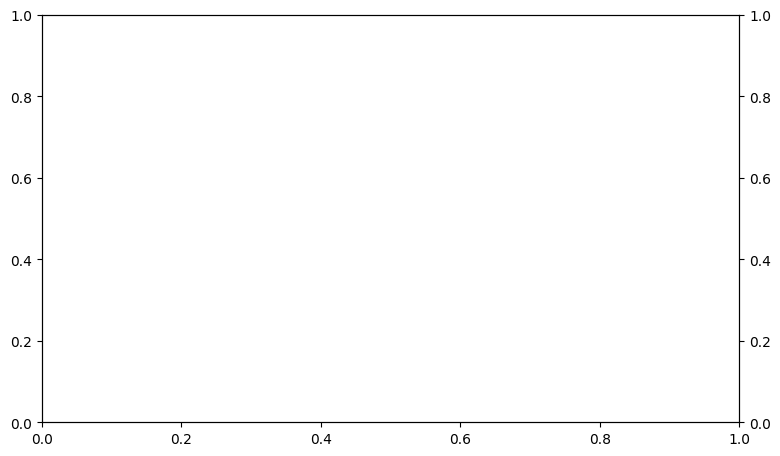

In [19]:
## plot result
fig = plt.figure(figsize=(9,18))

## set fig
for idx, df in enumerate(l_rate_df,1):
    ax1 = fig.add_subplot(len(l_rate_df),1,idx)
    ax2 = ax1.twinx()

    ## plot
    ax1.plot(df['time[ps]'], df['C12H12F12'], label = "C12H12F12", c='#C65D4D')
    ax1.plot(df['time[ps]'], df['CH2O'], label = "CH2O", c='#E66D0F')
    ax1.plot(df['time[ps]'], df['CO'], label = "CO", c='#729238')
    ax1.plot(df['time[ps]'], df['H2O'], label = "H2O", c='#7230A4')
    ax1.plot(df['time[ps]'], df['H2'], label = "H2", c='#0AB450')
    ax1.plot(df['time[ps]'], df['CH4'], label = "CH4", c='#1E4E7E')
    ax2.plot(df['time[ps]'], df['T[K]'], label = "T[K]", linewidth = 2, c='#8BB3E5')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()    

    ## format
    ax1.set_xlabel("Time /ps", fontsize=16)
    ax1.set_ylabel("Number of fragments", fontsize=16)
    ax2.set_ylabel("T /K", fontsize=16)
    ax1.set_xlim(0,25)
    ax1.set_ylim(0,25)
    ax2.set_ylim(0,2500)
    ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=14, bbox_to_anchor=(1.14, 1.02))
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    
fig.savefig('output/heatingrate_dependency.png', bbox_inches='tight',)